In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import re
from datetime import datetime
import math
import locale
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn import metrics
from xgboost import XGBRegressor, DMatrix
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt 

In [2]:
pd.set_option("display.max_columns", 100)

In [3]:
locale.setlocale(locale.LC_ALL, 'de_DE')

'de_DE'

In [4]:
phones = pd.read_csv('iphones.csv',sep = ";")

In [5]:
phones.shape

(16570, 26)

Take only listings, that are not active or not sold in 30 days (marked as old)

In [6]:
phones = phones.loc[(phones['active'] == False) | (phones['old'] == True)]

In [7]:
phones.shape

(10733, 26)

We don't want to analyse reselers wirth multiple items to sale in one listing

Dropping multiitem listings

In [8]:
phones = phones.loc[~(phones['multiple_items_available'] == True)]

Shape should stay the same, because they are active and not marked as old

In [9]:
phones.shape

(10733, 26)

Shape

Data fields

In [10]:
list(phones)

['_id',
 'active',
 'closure_date',
 'closure_reason',
 'color',
 'condition',
 'creation_date',
 'fianl_shipping_cost',
 'final_price',
 'last_update',
 'link',
 'memory',
 'mobile_operator',
 'model',
 'multiple_items_available',
 'number_of_reviews',
 'old',
 'page_not_found',
 'photos',
 'price',
 'return_policy',
 'search_term',
 'selers_feedback',
 'shipping_cost',
 'text_description',
 'title']

In [11]:
phones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10733 entries, 2 to 16417
Data columns (total 26 columns):
_id                         10733 non-null int64
active                      10733 non-null bool
closure_date                10179 non-null object
closure_reason              10633 non-null object
color                       8277 non-null object
condition                   10733 non-null object
creation_date               10733 non-null object
fianl_shipping_cost         10336 non-null object
final_price                 10633 non-null object
last_update                 10733 non-null object
link                        10733 non-null object
memory                      8277 non-null object
mobile_operator             7511 non-null object
model                       8272 non-null object
multiple_items_available    10733 non-null bool
number_of_reviews           10733 non-null int64
old                         100 non-null object
page_not_found              227 non-null object
photo

In [12]:
phones.isnull().sum()

_id                             0
active                          0
closure_date                  554
closure_reason                100
color                        2456
condition                       0
creation_date                   0
fianl_shipping_cost           397
final_price                   100
last_update                     0
link                            0
memory                       2456
mobile_operator              3222
model                        2461
multiple_items_available        0
number_of_reviews               0
old                         10633
page_not_found              10506
photos                          0
price                           0
return_policy                 547
search_term                     0
selers_feedback               679
shipping_cost                 140
text_description               43
title                           0
dtype: int64

It is critical to have NaN in model field

In [13]:
phones.loc[phones['model'].isnull() & ~(phones['price'].str.contains("£") | phones['price'].str.contains("\$"))].shape

(250, 26)

We were not interested in listings made from othe countries on other languages, but still there ar some in the dataset. Let's drop them

In [14]:
phones = phones.loc[~(phones['price'].str.contains("£") | phones['price'].str.contains("\$"))]

Checking left links manually...

In [15]:
phones.loc[phones['model'].isnull()].iloc[10].loc['link']

'https://www.ebay.de/itm/Apple-iPhone-6s-16GB-Silber-Ohne-Simlock-A1688-CDMA-GSM/164676486578?epid=216240876&hash=item26577bc5b2%3Ag%3A0VUAAOSwaXJgFTpl&LH_ItemCondition=3000&LH_BIN=1'

I found out, that there are some listings without model. It's possible to extract data from title. Just drop them now

In [16]:
phones = phones.loc[~phones['model'].isnull()]

In [17]:
phones.shape

(8272, 26)

Checking for duplicates

In [18]:
duplicated = phones.loc[phones.duplicated(keep=False)]

In [19]:
duplicated

Empty DataFrame
Columns: [_id, active, closure_date, closure_reason, color, condition, creation_date, fianl_shipping_cost, final_price, last_update, link, memory, mobile_operator, model, multiple_items_available, number_of_reviews, old, page_not_found, photos, price, return_policy, search_term, selers_feedback, shipping_cost, text_description, title]
Index: []

## Analyse closure_reason

In [20]:
phones['closure_reason'].describe()

count                              8212
unique                                9
top       Dieses Angebot wurde beendet.
freq                               3881
Name: closure_reason, dtype: object

In [21]:
reasons = phones['closure_reason'].unique()

In [22]:
for reason in reasons:
    print(reason)
    print(phones.loc[phones['closure_reason'] == reason].shape[0])

Dieses Angebot wurde vom Verkäufer beendet, da der Artikel nicht mehr verfügbar ist.
1491
Dieses Angebot wurde beendet.
3881
Dieses Angebot wurde vom Verkäufer beendet, da es einen Fehler enthielt.
1081
Dieser Artikel ist nicht vorrätig.
317
Dieses Angebot wurde beendet. Der Verkäufer hat diesen oder einen gleichartigen Artikel wiedereingestellt.
930
Das Sofort-Kaufen-Angebot wurde beendet.
393
Dieses Angebot wurde vom Verkäufer beendet, da der Artikel beschädigt wurde oder verloren ging.
84
nan
0
Das Sofort-Kaufen-Angebot wurde beendet. Der Verkäufer hat diesen oder einen gleichartigen Artikel wiedereingestellt.
17
Dieses Angebot wurde vom Verkäufer beendet, da der Artikel verkauft wurde.
18


Dieses Angebot wurde beendet. +
666
nan
0
Dieses Angebot wurde vom Verkäufer beendet, da der Artikel beschädigt wurde oder verloren ging. -
16
???????????? CHECK AGAIN ????????????Dieser Artikel ist nicht vorrätig. ? (not in stock) + There were several items and now sold out. We need this one.
217
Dieses Angebot wurde vom Verkäufer beendet, da der Artikel nicht mehr verfügbar ist. - Seller ands current offer onds opens another
383
Dieses Angebot wurde vom Verkäufer beendet, da es einen Fehler enthielt. -
184
Das Sofort-Kaufen-Angebot wurde beendet. + This was acution. Need to keep in mind that this one is auction!!!!
37
Dieses Angebot wurde beendet. Der Verkäufer hat diesen oder einen gleichartigen Artikel wiedereingestellt. - (duplicate)
109
Dieses Angebot wurde vom Verkäufer beendet, da der Artikel verkauft wurde. -
2
Das Sofort-Kaufen-Angebot wurde beendet. Der Verkäufer hat diesen oder einen gleichartigen Artikel wiedereingestellt. -
1

dpor rows with closure statuses that are out of scope

In [23]:
closure_reasons_out_of_scope = ['Dieses Angebot wurde vom Verkäufer beendet, da der Artikel beschädigt wurde oder verloren ging.', \
                               'Dieses Angebot wurde vom Verkäufer beendet, da der Artikel nicht mehr verfügbar ist.', \
                               'Dieses Angebot wurde vom Verkäufer beendet, da es einen Fehler enthielt.',\
                               'Dieses Angebot wurde beendet. Der Verkäufer hat diesen oder einen gleichartigen Artikel wiedereingestellt.',\
                               'Dieses Angebot wurde vom Verkäufer beendet, da der Artikel verkauft wurde.',\
                               'Das Sofort-Kaufen-Angebot wurde beendet. Der Verkäufer hat diesen oder einen gleichartigen Artikel wiedereingestellt.']

In [24]:
phones = phones.loc[~phones['closure_reason'].isin(closure_reasons_out_of_scope)]

## PRICE

In [25]:
phones.loc[~phones['price'].str.match('^EUR\s\d{1,3},\d{2}$') & ~phones['price'].str.match('^EUR\s\d.\d{1,3},\d{2}$')]

Empty DataFrame
Columns: [_id, active, closure_date, closure_reason, color, condition, creation_date, fianl_shipping_cost, final_price, last_update, link, memory, mobile_operator, model, multiple_items_available, number_of_reviews, old, page_not_found, photos, price, return_policy, search_term, selers_feedback, shipping_cost, text_description, title]
Index: []

There is one crazy high price and some prices wirh "/Stk." at the end

In [26]:
phones['price'] = phones['price'].map(lambda price: float(price.replace('.','').replace('/Stk','').replace("EUR", "").replace(",",".")))

In [27]:
phones['final_price'] = phones['final_price'].map(lambda price: price if (type(price) == float) else float(price.replace('.','').replace('/Stk','').replace("EUR", "").replace(",",".")))


for items which were not soled and marked as 'old' final price is null. need to fox it

In [28]:
def set_final_price_for_old_listings(row):
    return row["price"] if (row["old"] == True) else row["final_price"]

In [29]:
phones["final_price"] = phones.apply(set_final_price_for_old_listings, axis=1)

In [30]:
phones.loc[phones.final_price < 10, 'link'].size

10

In [31]:
phones['final_price'].describe()

count     4651.000000
mean       251.066209
std        448.566511
min          1.500000
25%         84.130000
50%        181.000000
75%        330.000000
max      27067.000000
Name: final_price, dtype: float64

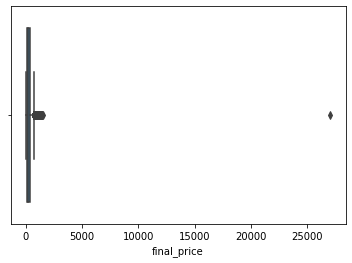

In [32]:
sns.boxplot(x=phones['final_price'])

In [33]:
phones.loc[phones['final_price'] > 2000].iloc[1].link

IndexError: single positional indexer is out-of-bounds

Important feature! Looks like iphones with installed game 'Fortnite' are really expensive

In [34]:
phones['title'] = phones['title'].str.lower()

In [35]:
phones.loc[(phones['title'].str.contains('fortnite')) & (phones['active'] == False)].iloc[6].link

IndexError: single positional indexer is out-of-bounds

In [36]:
phones = phones.loc[~phones['title'].str.contains('fortnite')]

check prices again

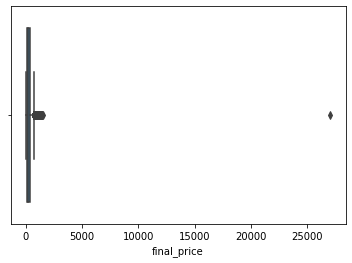

In [37]:
sns.boxplot(x=phones['final_price'])

In [38]:
phones.loc[phones['final_price'] > 1300].shape

(9, 26)

remove iphones that costs unrealistic expensive or cheap

In [39]:
phones = phones[(phones['final_price'] < 1300) & (phones['final_price'] > 10) ]

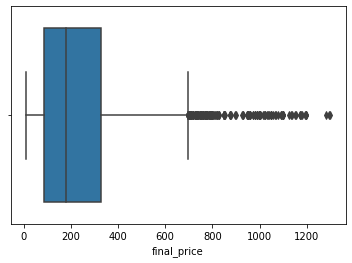

In [40]:
sns.boxplot(x=phones['final_price'])

## Check model

In [41]:
phones['model'] = phones['model'].str.lower()

remove "apple" at the beginning 

In [42]:
phones['model'] = phones['model'].map(lambda model: model.replace('apple ',''))

Number of Gb in the title could be valuable feature. I want to keep it, but separate from the model

In [43]:
phones["title_contains_memory_info"] = phones['model'].map(lambda model: bool(re.search("\dgb", model)))

In [44]:
phones["title_contains_memory_info"].describe()

count      4631
unique        2
top       False
freq       4627
Name: title_contains_memory_info, dtype: object

In [45]:
phones['model'] = phones['model'].map(lambda model: (re.sub(r"\d+gb", "", model)).strip())

In [46]:
phones['model'].unique()

array(['iphone 7', 'iphone 6s plus', 'iphone se', 'iphone 6s', 'iphone 8',
       'iphone 7 plus', 'iphone 8 plus', 'iphone se (2. generation)',
       'iphone 6', 'iphone 6 plus', 'iphone 11 pro max', 'iphone x', '',
       'iphone 2g', 'apple', 'iphone 11', 'iphone 5s',
       'iphone se  black ne', 'iphone xs', 'iphone xr', 'iphone 11 pro',
       'iphone xs max', 'iphone 4', 'iphone 4s', 'iphone 5',
       'iphone 12 5g 128 gb', 'iphone (1st generation)', 'iphone 12 mini',
       'iphone 12 mini 64 gb', 'iphone 12 pro max', 'iphone 12',
       'iphone 12 5g', 'iphone 12 pro', 'mgdf3zd/a', 'iphone 3g',
       'mge33zd/a', 'iphone 5c', 'a9', 'a11 bionic', 'a12 bionic',
       'i phone 7 / 5s / 4s / 4', 'iphone 6 plus a1524',
       'iphone se (2020)', 'mlxn2dn/a', 'iphone se 1', 'a8',
       'iphone 6 ???', 'a13 bionic', 'iphone 6+', 'iphone mini',
       'iphone 3gs', 'a10 fusion', 'iphone 6plus', 'iphone 8 plus 4g',
       'mwhr2zd/a', 'iphone 1', 'iphone se 256 gb weiss',
       '

In [47]:
iphone_se = ["se", "iphone se", "iphone se (1. generation)"]

In [48]:
iphone_se_2 = ["iphone se (2. generation)", "iphone se 2020", "iphone se 2"]

In [49]:
iphone_7 = ["iphone 7", "7"]

In [50]:
iphone_7_plus = ["iphone 7 plus"]

In [51]:
iphone_6 = ["iphone 6"]

In [52]:
iphone_6s = ["iphone 6s", "6s"]

In [53]:
iphone_6s_plus = ["iphone 6s plus"]

In [54]:
iphone_6_plus = ["iphone 6 plus"]

In [55]:
iphone_8_plus = ["iphone 8 plus"]

In [56]:
iphone_8 = ["iphone 8"]

In [57]:
iphone_11 = ["iphone 11"]

In [58]:
iphone_11_plus_max = ["iphone 11 pro max"]

In [59]:
iphone_11_pro =["iphone 11 pro"]

In [60]:
iphone_xr = ["iphone xr"]

In [61]:
iphone_x = ["iphone x"]

In [62]:
iphone_5 = ["iphone 5"]

In [63]:
iphone_5c = ["iphone 5c"]

In [64]:
iphone_5s = ["iphone 5s", "5s"]

In [65]:
iphone_xs = ["iphone xs", "xs"]

In [66]:
iphone_xs_max = ["iphone xs max", "xs max"]

In [67]:
all_models = [iphone_se, iphone_se_2, iphone_7, iphone_7_plus, iphone_6, iphone_6s, iphone_6s_plus, iphone_6_plus, \
              iphone_8_plus, iphone_8, iphone_11_plus_max, iphone_11_pro, iphone_xr, iphone_x, iphone_5, iphone_5c, \
             iphone_5s, iphone_xs, iphone_xs_max, iphone_11]

In [68]:
all_models_list = []
for models in all_models:
  all_models_list = all_models_list + models 

In [69]:
all_models_list

['se',
 'iphone se',
 'iphone se (1. generation)',
 'iphone se (2. generation)',
 'iphone se 2020',
 'iphone se 2',
 'iphone 7',
 '7',
 'iphone 7 plus',
 'iphone 6',
 'iphone 6s',
 '6s',
 'iphone 6s plus',
 'iphone 6 plus',
 'iphone 8 plus',
 'iphone 8',
 'iphone 11 pro max',
 'iphone 11 pro',
 'iphone xr',
 'iphone x',
 'iphone 5',
 'iphone 5c',
 'iphone 5s',
 '5s',
 'iphone xs',
 'xs',
 'iphone xs max',
 'xs max',
 'iphone 11']

I want to exclude models that are out of scope

In [70]:
exclude_models = [model for model in phones['model'].unique() if model not in all_models_list]

In [71]:
exclude_models

['',
 'iphone 2g',
 'apple',
 'iphone se  black ne',
 'iphone 4',
 'iphone 4s',
 'iphone 12 5g 128 gb',
 'iphone (1st generation)',
 'iphone 12 mini',
 'iphone 12 mini 64 gb',
 'iphone 12 pro max',
 'iphone 12',
 'iphone 12 5g',
 'iphone 12 pro',
 'mgdf3zd/a',
 'iphone 3g',
 'mge33zd/a',
 'a9',
 'a11 bionic',
 'a12 bionic',
 'i phone 7 / 5s / 4s / 4',
 'iphone 6 plus a1524',
 'iphone se (2020)',
 'mlxn2dn/a',
 'iphone se 1',
 'a8',
 'iphone 6 ???',
 'a13 bionic',
 'iphone 6+',
 'iphone mini',
 'iphone 3gs',
 'a10 fusion',
 'iphone 6plus',
 'iphone 8 plus 4g',
 'mwhr2zd/a',
 'iphone 1',
 'iphone se 256 gb weiss',
 'iphone 5s und 4s',
 'i phone 8',
 '6',
 'iphone7',
 '5c',
 'iphone se 2. generation',
 'a7',
 'mku62zd/a',
 'nicht zutreffend',
 'iphone',
 'i phone 6s']

In [72]:
phones = phones.loc[phones["model"].isin(all_models_list)]

In [73]:
phones['model'].unique()

array(['iphone 7', 'iphone 6s plus', 'iphone se', 'iphone 6s', 'iphone 8',
       'iphone 7 plus', 'iphone 8 plus', 'iphone se (2. generation)',
       'iphone 6', 'iphone 6 plus', 'iphone 11 pro max', 'iphone x',
       'iphone 11', 'iphone 5s', 'iphone xs', 'iphone xr',
       'iphone 11 pro', 'iphone xs max', 'iphone 5', 'iphone 5c', 'se',
       'xs', 'iphone se 2020'], dtype=object)

In [74]:
replace_model = {"6s": "iphone 6s", "7": "iphone 7", "5s": "iphone 5s", "se": "iphone se", 
                 "xs": "iphone xs", "xs max": "iphone xs max", "iphone se 2020": "iphone se 2", 
                 "iphone se (2. generation)": "iphone se 2", "iphone se (1. generation)": "iphone se"}

In [75]:
phones = phones.replace({"model": replace_model})

In [76]:
phones['model'].unique()

array(['iphone 7', 'iphone 6s plus', 'iphone se', 'iphone 6s', 'iphone 8',
       'iphone 7 plus', 'iphone 8 plus', 'iphone se 2', 'iphone 6',
       'iphone 6 plus', 'iphone 11 pro max', 'iphone x', 'iphone 11',
       'iphone 5s', 'iphone xs', 'iphone xr', 'iphone 11 pro',
       'iphone xs max', 'iphone 5', 'iphone 5c'], dtype=object)

## Analyse closure_date and creation_date

In [77]:
phones.loc[~(phones['closure_date'].isnull()) & ~(phones['closure_date'].str.match("^[0-3]\d\.\s[a-zA-Z]{3}\.\s20\d{2}", na = False))] 

Empty DataFrame
Columns: [_id, active, closure_date, closure_reason, color, condition, creation_date, fianl_shipping_cost, final_price, last_update, link, memory, mobile_operator, model, multiple_items_available, number_of_reviews, old, page_not_found, photos, price, return_policy, search_term, selers_feedback, shipping_cost, text_description, title, title_contains_memory_info]
Index: []

In [78]:
phones.loc[~(phones['last_update'].isnull()) & ~(phones['last_update'].str.match("^[0-3]\d\.\s[a-zA-Z]{3}\.\s20\d{2}", na = False))] 

Empty DataFrame
Columns: [_id, active, closure_date, closure_reason, color, condition, creation_date, fianl_shipping_cost, final_price, last_update, link, memory, mobile_operator, model, multiple_items_available, number_of_reviews, old, page_not_found, photos, price, return_policy, search_term, selers_feedback, shipping_cost, text_description, title, title_contains_memory_info]
Index: []

In [79]:
phones.loc[~(phones['creation_date'].str.match("^[0-3]\d\.\s[a-zA-Z]{3}\.\s\d{2}\:\d{2}\s20\d{2}", na = False))] 

Empty DataFrame
Columns: [_id, active, closure_date, closure_reason, color, condition, creation_date, fianl_shipping_cost, final_price, last_update, link, memory, mobile_operator, model, multiple_items_available, number_of_reviews, old, page_not_found, photos, price, return_policy, search_term, selers_feedback, shipping_cost, text_description, title, title_contains_memory_info]
Index: []

In [80]:
phones['closure_date'] = phones['closure_date'].str.extract(r'(^[0-3]\d\.\s[a-zA-Z]{3}\.\s20\d{2})')

In [81]:
phones['last_update'] = phones['last_update'].str.extract(r'(^[0-3]\d\.\s[a-zA-Z]{3}\.\s20\d{2})')

In [82]:
phones['creation_date'] = phones['creation_date'].map(lambda model: (re.sub(r"\d{2}\:\d{2}\s", "", model)))

In [83]:
phones['creation_date'] =  pd.to_datetime(phones['creation_date'], format='%d. %b. %Y')

In [84]:
phones['closure_date'] =  pd.to_datetime(phones['closure_date'], format='%d. %b. %Y')

In [85]:
phones['last_update'] =  pd.to_datetime(phones['last_update'], format='%d. %b. %Y')

Most likely all they 'out of stock'. Later they become closed by the customer. We may treat them as closed. If we don't have date (it's not displayed, when item is out of stock), we can use last update datae instead. We check data every day. It should be accurate enough


In [86]:
phones.loc[(phones["closure_date"].astype(str) == "NaT")].shape

(304, 27)

In [87]:
def set_closure_date(row):
    return row["last_update"] if (str(row["closure_date"]) == "NaT") else row["closure_date"]


In [88]:
phones["closure_date"] = phones.apply(set_closure_date, axis=1)

In [89]:
phones.loc[(phones["closure_date"].astype(str) == "NaT")].shape

(0, 27)

Those which don't have last update date just need to be removed (misssing data)

In [90]:
phones = phones.loc[~(phones["closure_date"].astype(str) == "NaT")]

In [91]:
phones['listing_was_active_before_closure'] = phones['closure_date'] - phones['creation_date']

In [92]:
phones['listing_was_active_before_closure'].head()

5    10 days
7     1 days
8     7 days
9     3 days
13    7 days
Name: listing_was_active_before_closure, dtype: timedelta64[ns]

In [93]:
phones['listing_was_active_before_closure'] = phones['listing_was_active_before_closure'].map(lambda date: date.days)

In [94]:
median = phones.loc[phones['listing_was_active_before_closure'] > 30, ['listing_was_active_before_closure']].median()

In [95]:
median

listing_was_active_before_closure    31.0
dtype: float64

In [96]:
phones = phones.fillna({'listing_was_active_before_closure': int(median)})

In [97]:
phones['listing_was_active_before_closure'].describe()

count    4380.000000
mean        4.681279
std         5.178368
min         0.000000
25%         1.000000
50%         3.000000
75%         7.000000
max        32.000000
Name: listing_was_active_before_closure, dtype: float64

In [98]:
phones['creation_date'].tail()

16358   2021-02-26
16364   2021-02-26
16374   2021-02-27
16389   2021-02-27
16417   2021-02-27
Name: creation_date, dtype: datetime64[ns]

## Condition field

In [99]:
phones['condition'].describe()

count                                                  4380
unique                                                  434
top       Gebraucht: Artikel wurde bereits benutzt. Ein ...
freq                                                   3810
Name: condition, dtype: object

In [100]:
phones['condition'].value_counts()

Gebraucht: Artikel wurde bereits benutzt. Ein Artikel mit Abnutzungsspuren, aber in gutem Zustand und\n... Mehr zum Thema                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 3810
“Artikelzustand: Gebraucht – sehr gut **** 4 von 5 Sternen ****”                                                                                                                                                                                                                                                                                                                                                         

In [101]:
# COMBINE WITTH TITLE

In [102]:
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [103]:
phones['condition']= phones['condition'].str.lower()

In [104]:
phones['title']= phones['title'].str.lower()

In [105]:
all_conditions = phones.loc[~phones.condition.str.contains("artikel wurde bereits benutzt. ein artikel mit abnutzungsspuren, aber in gutem zustand")]['condition'].str.split(' ')

In [106]:
all_titles = phones.loc[~phones.condition.str.contains("artikel wurde bereits benutzt. ein artikel mit abnutzungsspuren, aber in gutem zustand")]['condition'].str.split(' ')

In [107]:
all_conditions.shape

(568,)

In [108]:
all_conditions_cleaned = []

In [109]:
all_titles = []

In [110]:
for text in all_conditions:
    text = [x.strip(string.punctuation) for x in text]
    all_conditions_cleaned.append(text)

In [111]:
text_condition = [" ".join(text) for text in all_conditions_cleaned]
final_text_condition = " ".join(text_condition)
final_text_condition[:500]

'“kleine schattierungen&kratzer auf der rückseite kleine kratzer im glas sämtliche kratzer sind nicht wirklich störend zubehör neu und unbenutzt.” “optisch mittelmäßig gebrauchsspuren auf anhieb erkennbar voll funktionstüchtig artikel ist differenzbesteuert  siehe rechtliche informationen” “guter zustand” “smartphone ist funktionsfähig” “zustand akzeptabel ⭐⭐ display sehr gut erhalten rückseite 5-6 tiefe kratzer  lieferumfang handy inkl ladekabel  netzteil  getestet  gereinigt  vollständig desinf'

In [112]:
final_text_condition = final_text_condition.replace("gebraucht", "")

In [113]:
final_text_condition = final_text_condition.replace("und", "")

In [114]:
final_text_condition = final_text_condition.replace("artikel", "")

In [115]:
final_text_condition = final_text_condition.replace("gebrauchsspuren auf", "")

In [116]:
final_text_condition = final_text_condition.replace("sehr guter", "")

In [117]:
final_text_condition = final_text_condition.replace("das gerät", "")

In [118]:
["gebrauchsspuren", "guter zustand", "gebrauchsspuren auf", "keine kratzer"]

['gebrauchsspuren', 'guter zustand', 'gebrauchsspuren auf', 'keine kratzer']

In [119]:
["funktionstüchtig", "kratzer auf"]

['funktionstüchtig', 'kratzer auf']

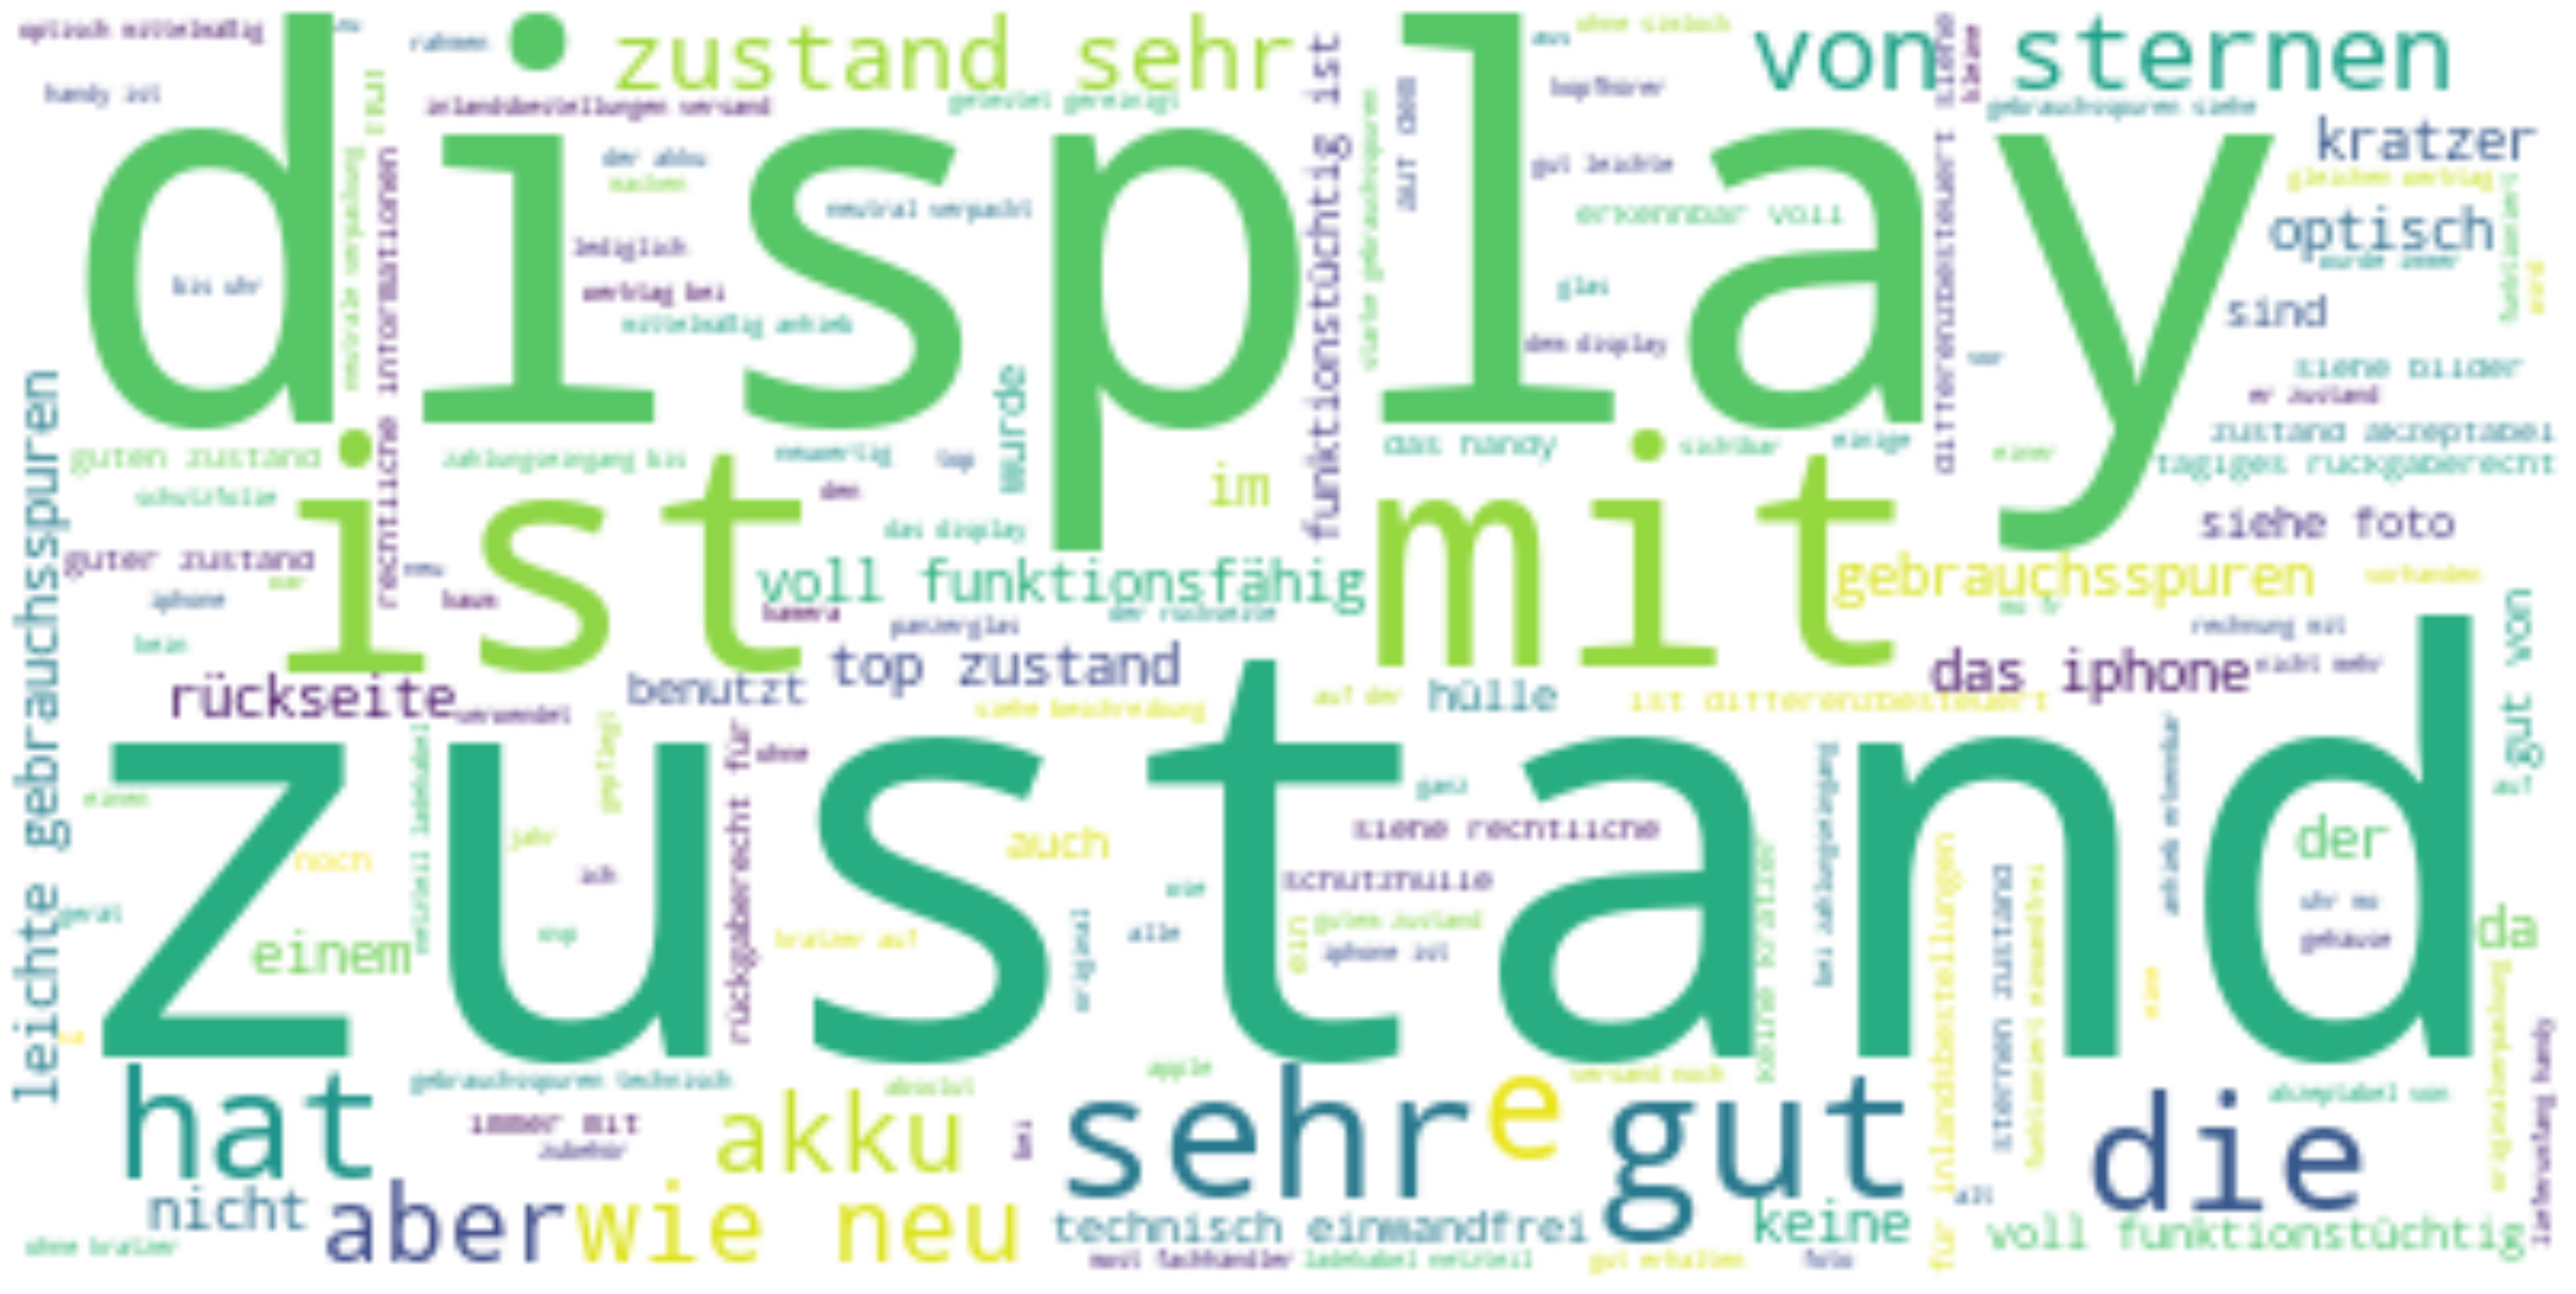

In [120]:
wordcloud_c = WordCloud(background_color="white").generate(final_text_condition)

# Lines 2 - 5
plt.figure(figsize = (50,40))
plt.imshow(wordcloud_c, interpolation='bilinear')
plt.axis("off")
plt.show()

In [121]:
phones['condition'].nunique()

427

In [122]:
positive_labels = ['sehr gut', 'top zustand', 'micro-kratzer', 'neuwertigen', 'keine kratzer', 'wie neu']

In [123]:
negative_labels = ['akzeptabel', 'starke gebrauchsspuren', 'schade']

In [124]:
phones.loc[phones.condition.str.contains('keine kratzer')].shape

(22, 28)

In [125]:
phones.loc[phones.title.str.contains('schade')].iloc[0].title

'iphone 8, 256 gb , leichter gehäuseschaden, gebraucht , gut erhalten'

In [126]:
phones['condition'].value_counts()

gebraucht: artikel wurde bereits benutzt. ein artikel mit abnutzungsspuren, aber in gutem zustand und\n... mehr zum thema                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 3810
“artikelzustand: gebraucht – sehr gut **** 4 von 5 sternen ****”                                                                                                                                                                                                                                                                                                                                                         

<font color=red>TODO: finish with it later</font>

In [127]:
phones['title']= phones['title'].str.lower()

In [128]:
all_titles = phones['title'].str.split(' ')

In [129]:
all_titles.shape

(4380,)

In [130]:
all_titles_cleaned = []

In [131]:
for text in all_titles:
    text = [x.strip(string.punctuation) for x in text]
    all_titles_cleaned.append(text)

In [132]:
text_titles = [" ".join(text) for text in all_titles_cleaned]
final_text_titles = " ".join(text_titles)
final_text_titles[:500]

'iphone 7 apple  128gb  schwarz  ohne simlock apple iphone 7  128gb  schwarz in ovp zubehörpaket neu apple iphone 6s plus  64gb  silber ohne simlock a1687 cdma  gsm apple iphone se 16gb space grau apple iphone se 2016 32gb 2016 space grau apple iphone 6s  64gb  space grau ohne simlock apple iphone se  128gb  roségold ohne simlock a1723 cdma  gsm apple iphone 8  64gb  silber ohne simlock a1905 gsm apple iphone se  32gb  space grau ohne simlock a1723 cdma  gsm apple iphone 7 plus 256gb schwarz appl'

In [133]:
stoptexts = ["apple", "iphone", "ohne simlock", "cdma", "gsm", "a1905", "space", "grey", "diamant", " s "]

In [134]:
memory_from_st = phones['memory'].str.lower().unique()

In [135]:
color_from_st = phones['color'].str.lower().unique()

In [136]:
stoptexts = all_models_list + stoptexts + memory_from_st.tolist() + color_from_st.tolist()

In [137]:
type(final_text_titles)

str

In [138]:
for text in stoptexts:
    final_text_titles = final_text_titles.replace(str(text), "")

In [139]:
import re


In [140]:

final_text_titles = re.sub('a\d+', '', final_text_titles)


In [141]:
final_text_titles = re.sub('\d+gb', '', final_text_titles)

In [142]:
final_text_titles

'   gb        gb   in ovp zubehörpaket neu plus                   2016  2016             gb  rosé                              plus             kein jahr alt       rosé                    plus                        rosé              viel zubehör  guter zustand   plus gb   akzeptabel             ohne sim-lock   plus        top zustand                      plus      ovp     akteptabel  lte   top mwst 102106               akzeptabel plus  gb                                        voll funktionsfähig model     2020   gb          top-zustand    gb                        rosé                   mit schutz    gb               rosé  akzeptabel      dual sim touch id ios lte bluetooth   plus              rosé o2        gb        plus  gb         gb           plus   plus gb rosé plus gb    plus  gb        gb product red special edition  voll funktionsfähig              gb                 gebraucht  top zustand  plus               mwst nicht ausweisbar                    akku 9  sipgen hülle     

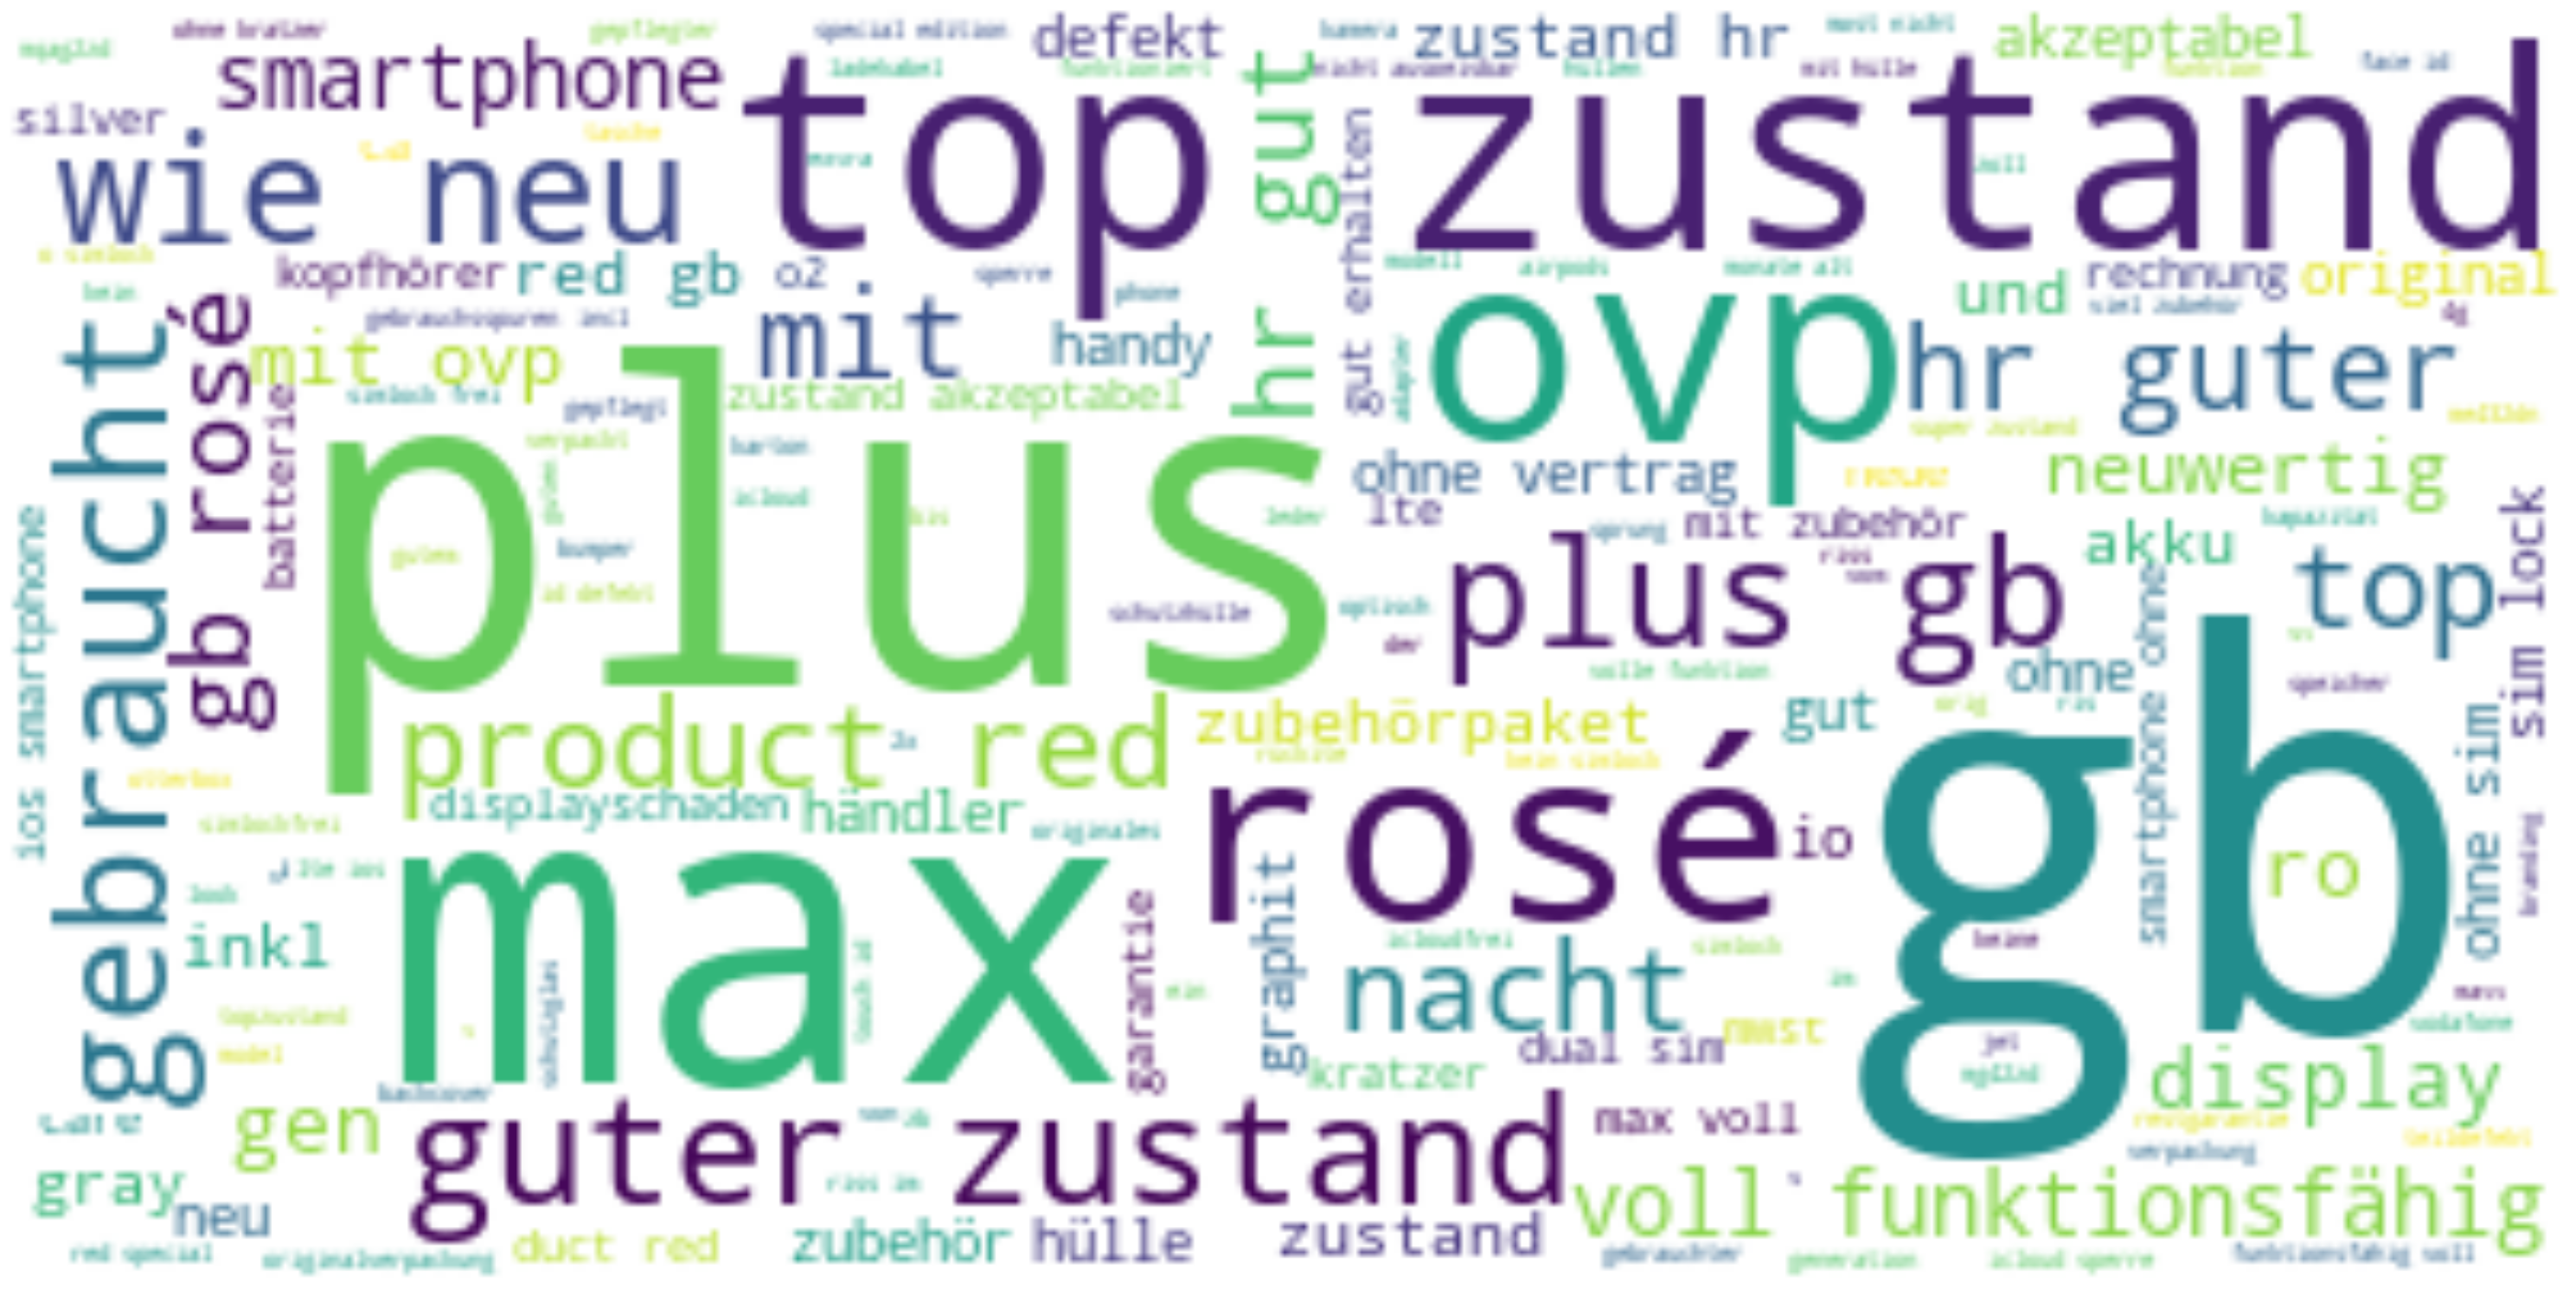

In [143]:
wordcloud_c = WordCloud(background_color="white").generate(final_text_titles)

# Lines 2 - 5
plt.figure(figsize = (50,40))
plt.imshow(wordcloud_c, interpolation='bilinear')
plt.axis("off")
plt.show()

In [144]:
phones['condition'].nunique()

427

## fianl_shipping_cost field

In [145]:
phones.fianl_shipping_cost = phones.fianl_shipping_cost.fillna(phones.shipping_cost)

what we have except of price in euro:

In [146]:
phones.loc[(~phones['fianl_shipping_cost'].isnull()) & ~(phones['fianl_shipping_cost'].str.match("^EUR\s\d+\,\d+", na = False)), "fianl_shipping_cost"].unique()

array(['KOSTENLOS', 'Abholung möglich', 'Kostenlose Abholung'],
      dtype=object)

In [147]:
phones.loc[(~phones['shipping_cost'].isnull()) & ~(phones['shipping_cost'].str.match("^EUR\s\d+\,\d+", na = False)), "shipping_cost"].unique()

array(['KOSTENLOS', 'Abholung möglich', 'Kostenlose Abholung'],
      dtype=object)

Checked manually. 'Abholung möglich' looks like an option for ebayplus. Could be replaced with 'KOSTENLOS'

In [148]:
phones.loc[phones['fianl_shipping_cost'] == 'Kostenlose Abholung', 'fianl_shipping_cost'].shape

(9,)

In [149]:
phones.loc[phones['shipping_cost'] == 'Standardversand', 'fianl_shipping_cost'].shape

(0,)

'Kostenlose Abholung' is extreamly rare case. Drop it

In [150]:
phones = phones.loc[~((phones['fianl_shipping_cost'].isin(['Kostenlose Abholung', 'Standardversand'])) | (phones['shipping_cost'].isin(['Kostenlose Abholung', 'Standardversand'])))]

In [151]:
phones['fianl_shipping_cost'] = phones['fianl_shipping_cost'].astype(str)
phones['shipping_cost'] = phones['shipping_cost'].astype(str)

In [152]:
phones['fianl_shipping_cost'] = phones['fianl_shipping_cost'].map(lambda price: price if (price == "nan") else 0 if price in ['KOSTENLOS', 'Abholung möglich'] else \
                                                                  float(price.replace("EUR", "").replace(",",".")))


In [153]:
phones['shipping_cost'] = phones['shipping_cost'].map(lambda price: price if (price == "nan") else 0 if price in ['KOSTENLOS', 'Abholung möglich'] else \
                                                                  float(price.replace("EUR", "").replace(",",".")))


In [154]:
phones['shipping_cost'].describe()

count     4371.00
unique      78.00
top          4.99
freq      2627.00
Name: shipping_cost, dtype: float64

In [155]:
phones['fianl_shipping_cost'].describe()

count     4371.00
unique      78.00
top          4.99
freq      2608.00
Name: fianl_shipping_cost, dtype: float64

In [156]:
phones['fianl_shipping_cost'] = phones['fianl_shipping_cost'].astype(float)

In [157]:
phones['shipping_cost'] = phones['shipping_cost'].astype(float)

## Memory column

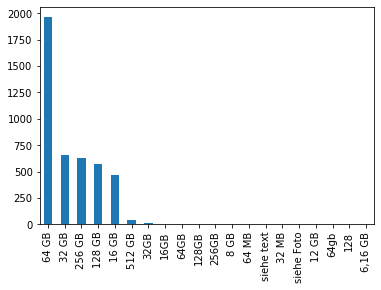

In [158]:
pd.value_counts(phones['memory']).plot.bar()

In [159]:
pd.value_counts(phones['memory'])

64 GB         1964
32 GB          660
256 GB         626
128 GB         573
16 GB          468
512 GB          38
32GB             8
16GB             7
64GB             7
128GB            5
256GB            3
8 GB             3
64 MB            2
siehe text       1
32 MB            1
siehe Foto       1
12 GB            1
64gb             1
128              1
6,16 GB          1
Name: memory, dtype: int64

remove whitespaces

In [160]:
phones['memory'] = phones['memory'].astype(str)


In [161]:
phones['memory'] = phones['memory'].map(lambda memory: memory.replace(" ","").strip())

In [162]:
pd.value_counts(phones['memory'])

64GB         1971
32GB          668
256GB         629
128GB         578
16GB          475
512GB          38
8GB             3
64MB            2
32MB            1
sieheFoto       1
siehetext       1
12GB            1
64gb            1
128             1
6,16GB          1
Name: memory, dtype: int64

In [163]:
low_frequency_memory_values = [memory for memory in phones['memory'].unique() if phones.loc[phones['memory'] == memory].shape[0] < 20]

In [164]:
low_frequency_memory_values

['64gb',
 'sieheFoto',
 '64MB',
 'siehetext',
 '12GB',
 '128',
 '8GB',
 '6,16GB',
 '32MB']

In [165]:
phones = phones.loc[~phones["memory"].isin(low_frequency_memory_values)]

mobile_operator field

In [166]:
pd.value_counts(phones["mobile_operator"])

Ohne Simlock                         3951
O2                                     20
Vodafone                               14
1&1                                    11
T-Mobile                                9
E-Plus+                                 7
A1 Telekom                              4
Telekom                                 3
Simlockfrei                             2
Frei ab Werk, Ohne Simlock              2
ohne Simlock                            2
Vodafone, VOXI                          1
aus ICloud entfernt, Ohne Simlock       1
Mobilkom A1                             1
1&1, Ohne Simlock                       1
ehemals vodafone, ohne Simlock          1
Name: mobile_operator, dtype: int64

In [167]:
phones['mobile_operator'] = phones['mobile_operator'].str.lower()

In [168]:
pd.value_counts(phones["mobile_operator"])

ohne simlock                         3953
o2                                     20
vodafone                               14
1&1                                    11
t-mobile                                9
e-plus+                                 7
a1 telekom                              4
telekom                                 3
frei ab werk, ohne simlock              2
simlockfrei                             2
ehemals vodafone, ohne simlock          1
mobilkom a1                             1
1&1, ohne simlock                       1
vodafone, voxi                          1
aus icloud entfernt, ohne simlock       1
Name: mobile_operator, dtype: int64

In [169]:
phones['mobile_operator'] = phones['mobile_operator'].astype(str)

In [170]:
phones['without_mobile_operator'] = phones['mobile_operator'].map(lambda operator : True if (operator == 'nan') else \
                                    True if any(free in operator for free in ["ohne simlock", "alle netze", "frei", "alle", "unlocked"]) \
                                    else False)


In [171]:
phones.loc[phones["without_mobile_operator"] == False,"mobile_operator"].unique()

array(['e-plus+', 'vodafone', 'o2', 'a1 telekom', '1&1', 't-mobile',
       'telekom', 'mobilkom a1', 'vodafone, voxi'], dtype=object)

## number_of_reviews field

In [172]:
phones["number_of_reviews"].describe()

count    4.359000e+03
mean     5.004905e+04
std      2.459879e+05
min      0.000000e+00
25%      4.400000e+01
50%      2.010000e+02
75%      6.380000e+02
max      1.336890e+06
Name: number_of_reviews, dtype: float64

looks good. the only issue is negative values

In [173]:
#phones.loc[phones["number_of_reviews"] < 0, ["link", "number_of_reviews"]].iloc[0].link

It's not an issue. It's negative reviews

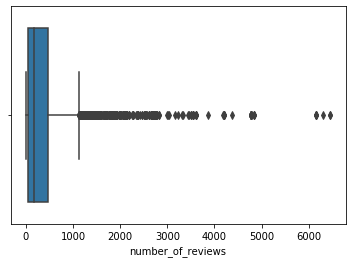

In [174]:
sns.boxplot(x=phones.loc[phones['number_of_reviews'] < 7000]['number_of_reviews'])

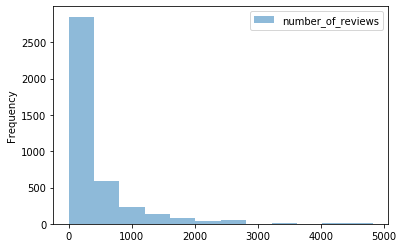

In [175]:
phones.loc[phones['number_of_reviews'] < 5000][['number_of_reviews']].plot.hist(bins=12, alpha=0.5)

## photos field

Analysing inages is out of scope now, but we can get nuber of images as an addtionl field

In [176]:
phones["number_of_photos"] = phones["photos"].map(lambda photos: len(photos.strip('][').split(', ')))

In [177]:
phones["number_of_photos"].describe()

count    4359.000000
mean        6.019729
std         3.181171
min         1.000000
25%         4.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: number_of_photos, dtype: float64

## return_policy field

In [178]:
phones['return_policy'] = phones['return_policy'].astype(str)

In [179]:
pd.value_counts(phones["return_policy"])

Keine Rücknahme                                                                    3888
Verbraucher können den Artikel zu den unten angegebenen Bedingungen zurückgeben     471
Name: return_policy, dtype: int64

In [180]:
phones["return_policy"].isnull().sum()

0

In [181]:
low_frequency_return_values = [return_policy for return_policy in phones['return_policy'].unique() if phones.loc[phones['return_policy'] == return_policy].shape[0] < 5]

In [182]:
low_frequency_return_values

[]

In [183]:
phones = phones.loc[~phones["return_policy"].isin(low_frequency_return_values)]

## selers_feedback field

In [184]:
pd.value_counts(phones["selers_feedback"]).describe()

count      75.000000
mean       53.160000
std       386.841962
min         1.000000
25%         2.000000
50%         3.000000
75%         7.000000
max      3354.000000
Name: selers_feedback, dtype: float64

In [185]:
phones["selers_feedback"].isnull().sum()

372

In [186]:
phones.loc[phones["selers_feedback"].isnull()].iloc[10]

_id                                                                       363272908773
active                                                                           False
closure_date                                                       2021-02-03 00:00:00
closure_reason                                           Dieses Angebot wurde beendet.
color                                                                              Rot
condition                            gebraucht: artikel wurde bereits benutzt. ein ...
creation_date                                                      2021-01-27 00:00:00
fianl_shipping_cost                                                               8.49
final_price                                                                        101
last_update                                                        2021-02-03 00:00:00
link                                 https://www.ebay.de/itm/Apple-iPhone-7-PRODUCT...
memory                                     

It's not a scrapping bug, sometimes there is no feedback

In [187]:
phones["no_feedback_yet"] = phones["selers_feedback"].isnull()

In [188]:
phones.iloc[0].selers_feedback

'100% Positive Bewertungen'

In [189]:
phones.loc[~(phones['selers_feedback'].isnull()) & ~(phones['selers_feedback'].str.match("^\d.+\%\sPositive Bewertungen", na = False))] 

Empty DataFrame
Columns: [_id, active, closure_date, closure_reason, color, condition, creation_date, fianl_shipping_cost, final_price, last_update, link, memory, mobile_operator, model, multiple_items_available, number_of_reviews, old, page_not_found, photos, price, return_policy, search_term, selers_feedback, shipping_cost, text_description, title, title_contains_memory_info, listing_was_active_before_closure, without_mobile_operator, number_of_photos, no_feedback_yet]
Index: []

In [190]:
phones['selers_feedback'] = phones['selers_feedback'].str.extract(r'(^\d.+\%)')

In [191]:
phones['selers_feedback'] = phones['selers_feedback'].map(lambda feedback: float(str(feedback).replace("%","").replace(",",".")))

In [192]:
phones = phones.fillna({"selers_feedback" : 100.0})

In [193]:
phones["selers_feedback"].describe()

count    4359.000000
mean       99.551319
std         2.963650
min        50.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: selers_feedback, dtype: float64

## text_description field

In [194]:
import time
round(time.time() * 1000)

1614442886924

In [195]:
#.to_datetime(phones['creation_date'], format='%d. %b. %Y')
#datetime.strptime()

In [196]:
a = datetime.strptime(re.sub(r"\d{2}\:\d{2}\s", "", "08. Sep. 00:30 2020"), '%d. %b. %Y')

In [197]:
None is None

True

## Color field

In [198]:
phones['color'].unique()

array(['Schwarz', 'Silber', 'Grau', 'Space Grau', 'Rosa', 'Gold', 'Rot',
       'Rose Gold', 'weiß/ grau', 'rot', 'Space-Grau', 'Space Grey',
       'Weiß', 'Spacegrau', 'blau', 'Grün', 'Lila', 'Gelb', 'weiß',
       'space grau', 'Orange', 'gelb', 'gold', 'silber', 'Grün/Türkis',
       'goldrose', 'Violett', 'Rosegold', 'Roségold', 'Blau', 'spacegrau',
       'Space Gray', 'Weiß Silber', 'koralle', 'Nachtgrün',
       'Weiß / silber', 'Silber/Weiss', 'Weiß/Gold', 'Spacegrey',
       'Rose Gold Rosegold', 'White', 'Purple', 'schwarz', 'rosegold',
       'Koralle', 'space gray', 'grau', 'diamantschwarz', 'space grey',
       'Weiss', 'Space Grery', 'weiss', 'Grau, silber, gold',
       'Mehrfarbig', 'Diamantschwarz', 'spacegrey', 'Gold Rose',
       'schwarzgrau', 'Black', 'Mint', 'Midnight Green'], dtype=object)

In [199]:
phones['color'] = phones['color'].astype(str)

In [200]:
phones['color'] = phones['color'].str.lower()

In [201]:
pd.value_counts(phones['color'])

grau                  1408
silber                 822
schwarz                815
gold                   537
rosa                   224
weiß                   153
rot                    124
grün                    99
blau                    22
gelb                    21
space grau              21
lila                    16
spacegrau               14
orange                  11
rosegold                11
space grey              10
roségold                 5
space gray               5
koralle                  4
rose gold                4
spacegrey                3
diamantschwarz           3
nachtgrün                3
gold rose                2
weiss                    2
weiß / silber            2
goldrose                 1
grau, silber, gold       1
black                    1
mehrfarbig               1
space grery              1
weiß/gold                1
schwarzgrau              1
mint                     1
weiß/ grau               1
space-grau               1
rose gold rosegold       1
w

In [202]:
color_dict = {"grey": "grau",
    "white": "weiß",
    "red": "rot",
    "weiss": "weiß",
    "black": "schwarz",
    "und": "",
    "/": "",
    "rose": "rosa",
    "silver": "silber",
    "rosé": "rosa",
    "rosè": "rosa",
    "pink": "rosa",
    "gray": "grau",
    " ": ""
}

In [203]:
def update_color(color):
    for key in color_dict.keys():
        color = color.replace(key, color_dict[key])
    return color

In [204]:
phones['color'] = phones['color'].map(lambda color: update_color(color))

In [205]:
low_frequency_color_values = [return_policy for return_policy in phones['color'].unique() if phones.loc[phones['color'] == return_policy].shape[0] < 20]

In [206]:
phones = phones.loc[~phones["color"].isin(low_frequency_color_values)]

## Condition field

In [207]:
phones['condition'] = phones['condition'].astype(str)

In [208]:
#phones['condition_short'] = phones['condition'].str.lower()

In [209]:
#phones['condition_short'] = phones['condition_short'].str.slice(stop=40)

In [210]:
phones['condition'].describe()

count                                                  4302
unique                                                  417
top       gebraucht: artikel wurde bereits benutzt. ein ...
freq                                                   3744
Name: condition, dtype: object

less than 10% contain additional info

## Encode categorical features

Prepared time periods

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4c361e048>]],
      dtype=object)

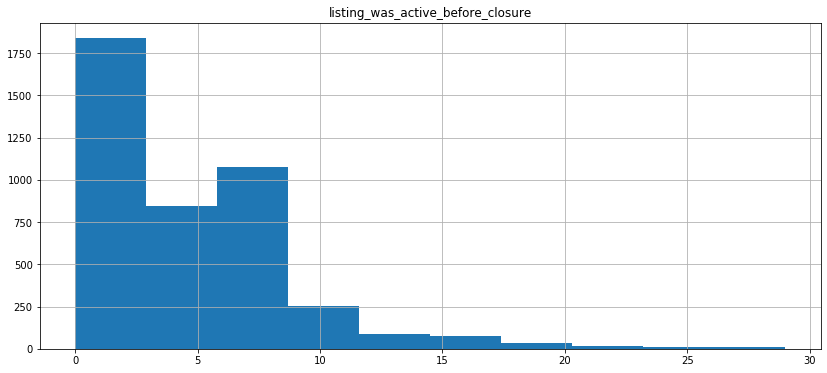

In [211]:
phones.loc[phones['listing_was_active_before_closure'] < 30, ["listing_was_active_before_closure"]].hist(figsize=[14,6])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4c0e41d68>]],
      dtype=object)

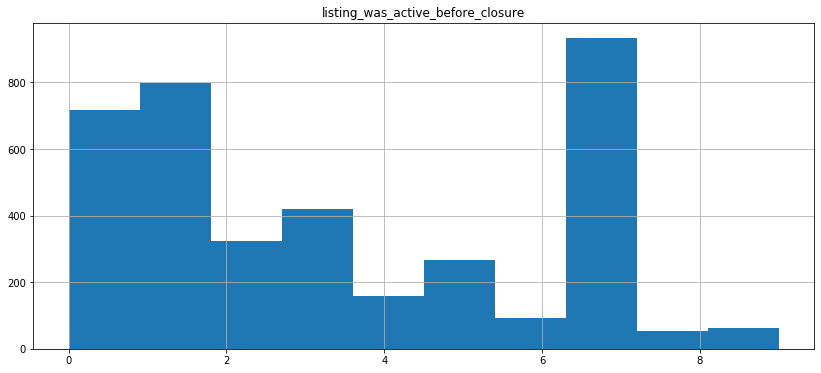

In [212]:
phones.loc[phones['listing_was_active_before_closure'] < 10, ["listing_was_active_before_closure"]].hist(figsize=[14,6])

Will use selling time goals: [1, 2..5, 6..10, 7..15, 16 .. 20, 21..30]

in first 3 days / in first 5 days/ in first 15 days / in first 30 days/ more than 30 or never

This will be the targert value for the multiclass classifiaction task

In [213]:
#phones['sell_in_more_than_30_days'] = phones['listing_was_active_before_closure'].map(lambda days: 1 if (days > 30) else 0)

In [214]:
#model_features = ['sell_in_more_than_30_days']

In [215]:
#for i in [[0,3], [4, 5], [6, 15], [16, 30]]:
    #column_name = 'sell_in_{0}_days'.format(i[1])
    #phones[column_name] = phones['listing_was_active_before_closure'].map(lambda days: \
                                                #1 if ((days <= i[1]) and (days >= i[0])) else 0)
    #model_features.append(column_name)

In [216]:
def get_category(days):
    for i in [[0, 2, 0], [3, 5, 1], [6, 10, 2], [11, 30, 3]]:
        if ((days <= i[1]) and (days >= i[0])):
            return i[2]
    if (days > 30):
        return 4

In [217]:
phones['selling_time_category'] = phones['listing_was_active_before_closure'].map(lambda days: get_category(days))

In [218]:
phones['selling_time_category'].isna().unique()

array([False])

In [219]:
model_features = ['selling_time_category']

In [220]:
model_features_text_model = ['selling_time_category']

In [221]:
phones.loc[phones['listing_was_active_before_closure'].isna()]

Empty DataFrame
Columns: [_id, active, closure_date, closure_reason, color, condition, creation_date, fianl_shipping_cost, final_price, last_update, link, memory, mobile_operator, model, multiple_items_available, number_of_reviews, old, page_not_found, photos, price, return_policy, search_term, selers_feedback, shipping_cost, text_description, title, title_contains_memory_info, listing_was_active_before_closure, without_mobile_operator, number_of_photos, no_feedback_yet, selling_time_category]
Index: []

In [222]:
phones = phones.reset_index()

In [223]:
features_for_one_hot_enc = ["model", "color", "memory", 'return_policy']

In [224]:
for feature in features_for_one_hot_enc:
    phones[feature] = feature + "_" + phones[feature]

In [225]:
features_for_one_hot_enc = ["color", "memory", 'return_policy']

In [226]:
encoder = OneHotEncoder()
encoded = encoder.fit_transform(phones.loc[:, features_for_one_hot_enc]);
categories = []
for i in range(0, len(encoder.categories_)):
    categories = np.concatenate((categories, encoder.categories_[i]), axis=None)
for i in range(0, len(categories)):
    phones = pd.concat([phones, pd.DataFrame(encoded[:,i].toarray(), columns = [categories[i]])], axis=1, sort=False)

In [227]:
model_features.extend(categories)

## Encode binary values 

In [228]:
phones['old'].unique() #don't use them. Already added number big value before the sale days

array([nan, True], dtype=object)

In [229]:
phones["no_feedback_yet"].unique()

array([False,  True])

In [436]:
phones["no_feedback_yet"] = phones["no_feedback_yet"].astype(int)

In [437]:
model_features.append('no_feedback_yet')

## Numerical values

price and final_price: need combine them

In [438]:
def set_price(row):
    if (math.isnan(row['final_price'])):
        return row['price']
    else:
        return row['final_price']

In [439]:
phones["price"] = phones.apply(set_price, axis=1)

fianl_shipping_cost and shipping_cost: need combine them

In [440]:
def set_shipping(row):
    if (math.isnan(row['fianl_shipping_cost'])):
        return row['shipping_cost']
    else:
        return row['fianl_shipping_cost']

In [441]:
phones["shipping_cost"] = phones.apply(set_shipping, axis=1)

In [442]:
phones["shipping_cost"].describe()

count    14583.000000
mean         4.122722
std          2.618936
min          0.000000
25%          2.990000
50%          4.990000
75%          4.990000
max         50.000000
Name: shipping_cost, dtype: float64

In [443]:
phones["number_of_reviews"].isna().unique()

array([False])

remove reselers

In [444]:
phones = phones.loc[phones["number_of_reviews"] < 5000]

In [445]:
phones["number_of_photos"].describe()

count    12520.000000
mean         6.196645
std          3.109471
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         18.000000
Name: number_of_photos, dtype: float64

In [446]:
phones["selers_feedback"].describe()

count    12520.000000
mean        99.565463
std          2.731891
min         33.300000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: selers_feedback, dtype: float64

In [447]:
model_features.extend(["price", "shipping_cost", "number_of_reviews", "number_of_photos", "selers_feedback", "price_difference", 
                       "total_price"])

In [448]:
model_features_text_model.extend(["cnn_{}".format(x) for x in range(0, 300)])

In [449]:
model_features_text_model.extend(["15_percent_expensive", "text_description_len", "price_difference"])

### MEAN PRICE

In [450]:
phones["total_price"] = phones["price"] + phones["shipping_cost"]

In [451]:
mean_prices = phones.groupby(['model', 'memory', 'color'])['total_price'].mean().reset_index()


In [452]:
mean_prices.loc[mean_prices.model == "model_iphone 8"]

model        memory            color  total_price
242  model_iphone 8  memory_128GB       color_gold   164.990000
243  model_iphone 8  memory_128GB       color_grau   279.304444
244  model_iphone 8  memory_128GB     color_silber   416.990000
245  model_iphone 8  memory_256GB       color_gold   312.967273
246  model_iphone 8  memory_256GB       color_grau   273.223125
247  model_iphone 8  memory_256GB       color_rosa   209.990000
248  model_iphone 8  memory_256GB        color_rot   275.851429
249  model_iphone 8  memory_256GB     color_silber   268.424000
250  model_iphone 8  memory_256GB       color_weiß   234.990000
251  model_iphone 8   memory_32GB       color_grau   119.490000
252  model_iphone 8   memory_32GB    color_schwarz   157.500000
253  model_iphone 8   memory_64GB       color_gold   220.097962
254  model_iphone 8   memory_64GB       color_grau   206.819892
255  model_iphone 8   memory_64GB       color_rosa   194.974286
256  model_iphone 8   memory_64GB   color_rosagold   205.073333
257  model_iphone 8   memory_64GB        color_rot   217.470741
258  model_iphone 8   memory_64GB    color_schwarz   194.012174
259  model_iphone 8   memory_64GB     color_silber   209.407012
260  model_iphone 8   memory_64GB  color_spacegrau   235.906364
261  model_iphone 8   memory_64GB       color_weiß   195.958125
262  model_iphone 8    memory_nan       color_grau   187.450000
263  model_iphone 8    memory_nan        color_nan   310.730000

In [453]:
mean_prices.head(1)

model        memory       color  total_price
0  model_iphone 11  memory_128GB  color_gelb        595.0

In [454]:
mean_prices.loc[(mean_prices.model == "model_iphone 11") & (mean_prices.memory  == "memory_128GB") & (mean_prices.color == "color_gelb")].total_price[0]

595.0

In [455]:
def set_mean_price(row):
    price = mean_prices.loc[(mean_prices.model == row.model) & (mean_prices.memory  == row.memory) 
                            & (mean_prices.color == row.color)].total_price
    return price.tolist()[0]


In [456]:
phones["mean_price"] = phones.apply(set_mean_price, axis=1)


In [457]:
phones[["price", "shipping_cost", "total_price", "mean_price"]].head(1)


price  shipping_cost  total_price  mean_price
0   59.0           4.99        63.99      73.246

In [458]:
phones["price_difference"] = (phones["total_price"] - phones["mean_price"])/phones["mean_price"]

In [459]:
phones[["price", "shipping_cost", "total_price", "mean_price", "price_difference"]].head(1)


price  shipping_cost  total_price  mean_price  price_difference
0   59.0           4.99        63.99      73.246         -0.126369

In [460]:
phones.shape

(12520, 63)

In [461]:
phones.loc[(phones["price_difference"] > 0.15) & (phones["selling_time_category"] < 4)].shape

(1217, 63)

In [462]:
positive_ranges = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7]

In [463]:
positive_n = []

In [464]:
for r in positive_ranges:
    positive_n.append(phones.loc[(phones["price_difference"] > r) & (phones["selling_time_category"] < 4)].shape[0])
    

In [465]:
positive_n

[3956, 2889, 1871, 1217, 752, 452, 317, 145, 85, 57, 35]

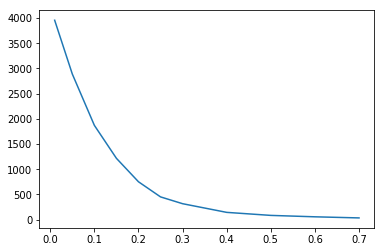

In [466]:
plt.plot(positive_ranges, positive_n)

15% looks reasonable

In [467]:
phones["15_percent_expensive"] = (phones["price_difference"] > 0.15) & (phones["selling_time_category"] < 4)

In [468]:
phones["15_percent_expensive"] = phones["15_percent_expensive"].astype(int)

In [469]:
phones.tail(3)

index           _id  active closure_date  \
14581  36059  203215042750   False   2020-12-11   
14582  36067  174553876111   False   2020-12-11   
14583  36103  324413177796   False   2020-12-11   

                      closure_reason         color  \
14581  Dieses Angebot wurde beendet.    color_grau   
14582  Dieses Angebot wurde beendet.  color_silber   
14583  Dieses Angebot wurde beendet.    color_grün   

                                               condition creation_date  \
14581  Gebraucht: Artikel wurde bereits benutzt. Ein ...    2020-12-11   
14582  Gebraucht: Artikel wurde bereits benutzt. Ein ...    2020-12-11   
14583  Gebraucht: Artikel wurde bereits benutzt. Ein ...    2020-12-11   

       fianl_shipping_cost  final_price last_update  \
14581                 0.00        79.95  2020-12-11   
14582                 4.99       160.00  2020-12-11   
14583                 4.99       620.00  2020-12-11   

                                                    link       memory  \
14581  https://www.ebay.de/itm/Apple-iPhone-SE-64GB-S...  memory_64GB   
14582  https://www.ebay.de/itm/Apple-iPhone-8-64GB-Si...  memory_64GB   
14583  https://www.ebay.de/itm/Apple-iPhone-11-Pro-64...  memory_64GB   

      mobile_operator                model multiple_items_available  \
14581    ohne simlock      model_iphone se                    False   
14582    ohne simlock       model_iphone 8                    False   
14583    ohne simlock  model_iphone 11 pro                    False   

       number_of_reviews  old page_not_found  \
14581                115  NaN            NaN   
14582                  0  NaN            NaN   
14583                 37  NaN            NaN   

                                                  photos   price  \
14581  ['https://i.ebayimg.com/images/g/iTEAAOSwO-Jf0...   79.95   
14582  ['https://i.ebayimg.com/images/g/S5AAAOSwif9f0...  160.00   
14583  ['https://i.ebayimg.com/images/g/ptoAAOSweNpf0...  620.00   

                                           return_policy search_term  \
14581  return_policy_Verbraucher können den Artikel z...   iphone SE   
14582                      return_policy_Keine Rücknahme    iphone 6   
14583  return_policy_Verbraucher können den Artikel z...   iphone 11   

       selers_feedback  shipping_cost  \
14581            100.0           0.00   
14582            100.0           4.99   
14583            100.0           4.99   

                                        text_description  \
14581  Zum Verkauf angeboten wird hier ein\n\nApple i...   
14582  Apple iPhone 8 - 64GB - Silber (Ohne Simlock) ...   
14583  Apple iPhone 11 Pro - 64GB - Nachtgrün (Ohne S...   

                                                   title  \
14581  apple iphone se 64gb space grau - sehr gut *hä...   
14582  apple iphone 8 - 64gb - silber (ohne simlock) ...   
14583  apple iphone 11 pro - 64gb - nachtgrün (ohne s...   

       title_contains_memory_info  listing_was_active_before_closure  \
14581                       False                                  0   
14582                       False                                  0   
14583                       False                                  0   

       without_mobile_operator  number_of_photos  no_feedback_yet  \
14581                     True                 5                0   
14582                     True                 5                1   
14583                     True                 6                0   

       selling_time_category  color_blau  color_gelb  color_gold  color_grau  \
14581                      0         0.0         0.0         0.0         1.0   
14582                      0         0.0         0.0         0.0         0.0   
14583                      0         0.0         0.0         0.0         0.0   

       color_grün  color_lila  color_nan  color_orange  color_rosa  \
14581         0.0         0.0        0.0           0.0         0.0   
14582         0.0         0.0        0.0           0.0      

In [470]:
phones["price_difference"].describe()

count    1.252000e+04
mean     1.985931e-16
std      2.794544e-01
min     -9.415869e-01
25%     -1.452652e-01
50%     -2.108982e-02
75%      9.899679e-02
max      5.695349e+00
Name: price_difference, dtype: float64

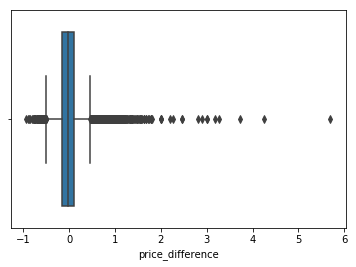

In [471]:
sns.boxplot(x=phones['price_difference'])

In [484]:
phones.loc[phones["price_difference"] >1].shape

(109, 64)

In [477]:
phones.shape

(12520, 64)

## TODO LIST


condition

text_description

extract day of the week and time of listing creation

days ago from creation date

add summ of shipping and price

try what will be the score if i remove "Dieses Angebot wurde vom Verkäufer beendet, da der Artikel verkauft wurd" reason. That means I will remova auction

remove big reselers


## Model

In [ ]:
normalize = {" ": "_", "ö": "o", "ä": "a", "ß": "ss", "ü": "u"}

In [ ]:
for key in normalize:
    phones.columns = phones.columns.str.replace(key, normalize[key])

In [ ]:
rename_columns = {
                    "return_policy_Verbraucher_konnen_den_Artikel_zu_den_unten_angegebenen_Bedingungen_zuruckgeben_Kaufer_zahlt_Ruckversand": "return_policy_seller_pays",
                    "return_policy_Verbraucher_konnen_den_Artikel_zu_den_unten_angegebenen_Bedingungen_zuruckgeben": "return_policy_buyer_pays",
    "return_policy_Keine_Rucknahme": "return_policy_no_return"}

In [ ]:
phones = phones.rename(rename_columns, axis=1)

In [ ]:
phones_filename = 'phones.pkl'
phones.to_pickle(phones_filename)

In [ ]:
phones = pd.read_pickle(phones_filename)

features

In [ ]:
for key in normalize:
    model_features = [w.replace(key, normalize[key]) for w in model_features]

In [ ]:
for key in rename_columns:
    model_features.remove(key)
    model_features.append(rename_columns[key])


In [ ]:
model_features_text_filename = 'model_features_text.pkl'

In [ ]:
model_features_filename = 'model_features.pkl'

In [ ]:
pickle.dump(model_features_text_model, open(model_features_text_filename, 'wb'))

In [ ]:
pickle.dump(model_features, open(model_features_filename, 'wb'))


In [ ]:
loaded_model_feature = pickle.load(open(model_features_filename, 'rb'))

In [ ]:
loaded_model_text_feature = pickle.load(open(model_features_text_filename, 'rb'))

In [ ]:
model_features = loaded_model_feature

In [ ]:
model_features_text_model = loaded_model_text_feature

In [ ]:
model_features.append('mean_price')

In [ ]:
model_features

In [ ]:
all_data = phones[["_id"]]

In [ ]:
all_data_text_model = phones[["_id"]]

In [ ]:
model_features.append("_id")

In [ ]:
# for mean encoding
model_features.append("model")

In [ ]:
model_features_text_model.append("_id")

In [ ]:
all_data_text_model = pd.merge(all_data_text_model, phones[model_features_text_model], on=['_id'], how='left')

In [ ]:
all_data = pd.merge(all_data, phones[model_features], on=['_id'], how='left')

#TODO check if "return_policy_Verbraucher_konnen_den_Artikel_zu_den_unten_angegebenen_Bedingungen_zurückgeben" really always means that buyer pays

In [ ]:
data_filename = 'all_data.pkl'
all_data.to_pickle(data_filename)

In [ ]:
all_data = pd.read_pickle(data_filename)


In [ ]:
train, test = train_test_split(all_data, test_size=0.2, random_state=42)

## Mean encode model (can be done only after the split)

In [ ]:
cumsum = train.groupby('model')['mean_price'].cumsum() - train['mean_price']

In [ ]:
cumc = train.groupby('model').cumcount() + 1

In [ ]:
train['model_enc'] = cumsum/cumc

In [ ]:
train = train.drop(['model'], axis=1)

In [ ]:
###testtit 

In [ ]:
only_soled_items = all_data_text_model.loc[all_data_text_model.selling_time_category < 4]

In [ ]:
only_soled_items = only_soled_items.loc[only_soled_items.price_difference < 2]

In [ ]:
only_soled_items['price_difference'].describe()

In [ ]:
train_text, test_text = train_test_split(only_soled_items, test_size=0.2, random_state=42)

In [ ]:
X_train = train.drop(['selling_time_category', '_id'], axis=1)
X_test = test.drop(['selling_time_category', '_id'], axis=1)

In [ ]:
X_train_text = train_text.drop(['selling_time_category', '_id', '15_percent_expensive', 'text_description_len', "price_difference"], axis=1)
X_test_text = test_text.drop(['selling_time_category', '_id', '15_percent_expensive', 'text_description_len', "price_difference"], axis=1)

In [ ]:
Y_train = train['selling_time_category']
Y_test = test['selling_time_category']

In [ ]:
Y_train_text = train_text['selling_time_category']
Y_test_text = test_text['selling_time_category']

In [ ]:
Y_train_text_15 = train_text['15_percent_expensive']
Y_test_text_15 = test_text['15_percent_expensive']

In [ ]:
Y_train_text_price_dif = train_text['price_difference']
Y_test_text_price_dif = test_text['price_difference']

In [ ]:
# don't use. for evaluation set not enough data

In [ ]:
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [ ]:
phones.loc[phones['selling_time_category'].isna()]